# Hypothesis and Goals

Prev returns of stocks like (BTC, SOLANA, ETHEREUM) --> can be used to predict some shitty ass stocks

Reason

    - shitty stocks should to react to beta
    - but they react slowly, low liquidity


# Investigation

1. Find top correlated stock with Indicator stocks' prevTimerange returns
2. Bin by Indicator's prevTimerange returns --> see what corr stock's returns look like on avg.
    check in train data
    then test data should look similar
3. Backtest a strategy and view pnl

In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv('./crypto_data.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df.head()
print("Daterange:", df.index[0], df.index[-1])

Daterange: 2024-07-01 00:00:00 2024-11-30 16:00:00


In [16]:
# Change time range
df = df.iloc[::2]

In [17]:
# Train range: September to October end
start_train  = datetime(2024, 10, 10)
end_train = datetime(2024, 11, 20)
end_test = datetime(2024, 11, 30, 15)
train_df = df.loc[start_train:end_train]
test_df = df.loc[end_train + timedelta(hours=1):end_test]

In [18]:
def getReturnDf(data):
    data = data.dropna(how='any', axis=1).copy()

    # Get most stock returns
    stocks = [colName.split('_')[0] for colName in data.columns]

    stock_returns = {
        f'{stock}_return': (data[f'{stock}_close'] - data[f'{stock}_close'].shift(1))/data[f'{stock}_close'].shift(1)*100*100
        for stock in stocks
    }

    # Get indicator returns, shifted extra
    indicators = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
    indicator_returns = {
        f'{indicator}_prev_return': ((data[f'{indicator}_close'] - data[f'{indicator}_close'].shift(1))/data[f'{indicator}_close'].shift(1)).shift(1)*100*100
        for indicator in indicators
    }

    return_df = pd.DataFrame({**stock_returns, **indicator_returns})
    return_df = return_df.drop(labels=return_df.index[:2], axis=0)
    return return_df

train_returns = getReturnDf(train_df)
test_returns = getReturnDf(test_df)

In [26]:
# Find most correlated with BTC return prev
topCorr = train_returns.corrwith(train_returns['BTCUSDT_prev_return'], axis=0).sort_values(ascending=False)
topCorr.head(30)

BTCUSDT_prev_return    1.000000
ETHUSDT_prev_return    0.781545
SOLUSDT_prev_return    0.728163
NYANUSDT_return        0.155603
AEVOPERP_return        0.140837
MNTPERP_return         0.135356
DEXEUSDT_return        0.130077
OSMOUSDT_return        0.128663
BOBAUSDT_return        0.128222
POLPERP_return         0.121032
BTC-26SEP25_return     0.095184
PRIMEUSDT_return       0.093453
STRKPERP_return        0.092117
ORCAUSDT_return        0.091703
AEROUSDT_return        0.090778
BTC-27JUN25_return     0.084051
NOTPERP_return         0.083213
BTC-28MAR25_return     0.078793
10000WENUSDT_return    0.075295
XRDUSDT_return         0.074669
ORDIPERP_return        0.073947
AIOZUSDT_return        0.073795
10000COQUSDT_return    0.073763
FIREUSDT_return        0.072757
BNBPERP_return         0.070125
1000BTTUSDT_return     0.069745
WLDPERP_return         0.068075
BTC-27DEC24_return     0.065354
MOBILEUSDT_return      0.064651
SHIB1000PERP_return    0.064605
dtype: float64

/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


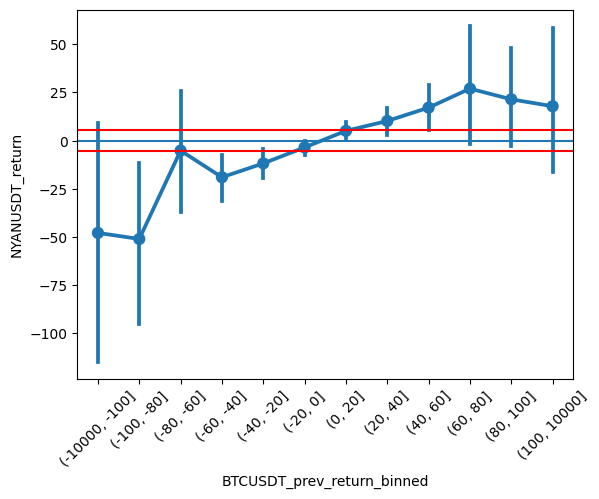

/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


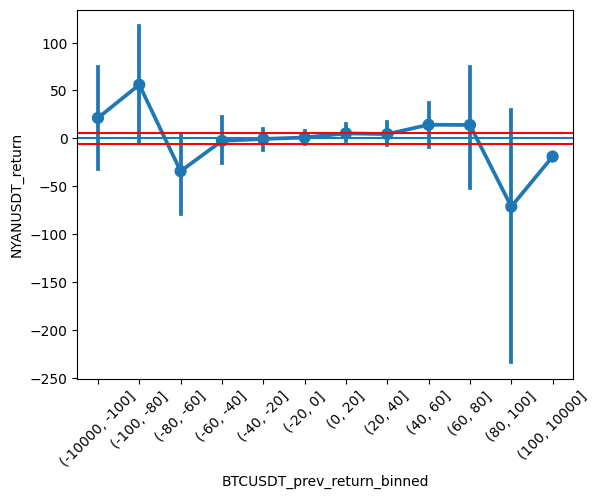

In [27]:
import statsmodels.api as sm

def binnedReturnComparison(data, x, y):
    bins = [-10000] + list(np.arange(-100, 101, 20)) + [10000]
    
    data = data.copy()
    data.loc[:,f'{x}_binned'] = pd.cut(data[x], bins=bins)
    # data.loc[:,f'{x}_binned'] = pd.qcut(data[x], 20)
    # display(data[f'{x}_binned'].value_counts(normalize=True))

    sns.pointplot(data=data, x=f'{x}_binned', y=y)
    plt.xticks(rotation=45)
    plt.axhline(y=0)
    plt.axhline(y=5.5, color='red')
    plt.axhline(y=-5.5, color='red')
    plt.show()

    # model = sm.OLS(data[y], sm.add_constant(data[x])).fit()
    # print(model.summary())

    # sns.residplot(data=data, x=x, y=y)
    # plt.show()

stocks = ['NYANUSDT_return', 'ETHFIPERP_return', 'ARBPERP_return', 'OSMOUSDT_return', 'SHIB1000PERP_return', 'DEXEUSDT_return', 'DGBUSDT_return']
binnedReturnComparison(train_returns, 'BTCUSDT_prev_return', stocks[0])
binnedReturnComparison(test_returns, 'BTCUSDT_prev_return', stocks[0])

# Findings

Fees wipe out a lot of profits, usually containing the [0-10] and [10-20] buckets

- ETHFIPERP looks promising, with only the [0-10] buckets contained in the fee line